# Ptychographic Reconstructions

Ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities in the far-field:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

## Electrostatic Potential Reconstruction

In this tutorial, we use [regularized PIE](https://doi.org/10.1364/OPTICA.4.000736) to reconstruct the electrostatic potential of a crystalline sample.

More specifically, we wish to reconstruct the projected electrostatic potential contributions to the Aharonov-Bohm phase shift given by:

$$
\begin{align}
    \phi_e(\boldsymbol{r}_\bot) = \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz 
\end{align}
$$

We consider a (thin) slab of [110] STO:

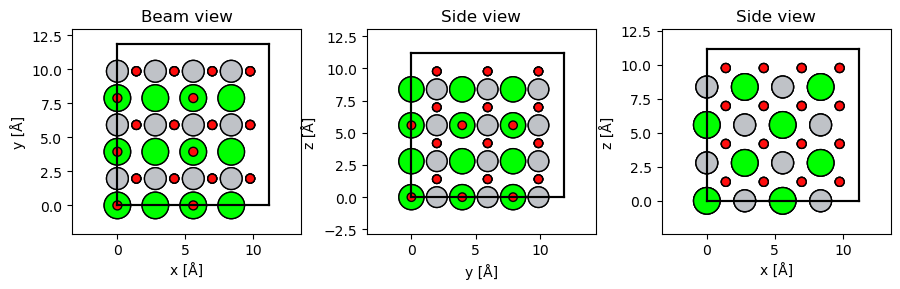

In [5]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell   = read('data/SrTiO3.cif')
STO_atoms       = surface(STO_unit_cell, (1,1,0), 4, periodic=True)*(2,3,1)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))

show_atoms(STO_atoms, ax = ax1, title = 'Beam view')
show_atoms(STO_atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(STO_atoms, ax = ax3, plane = 'xz', title = 'Side view')

fig.tight_layout();

We'll use `FrozenPhonons` to broaden our potentials to simulate finite temperature, and a fairly aberrated probe for our simulations:

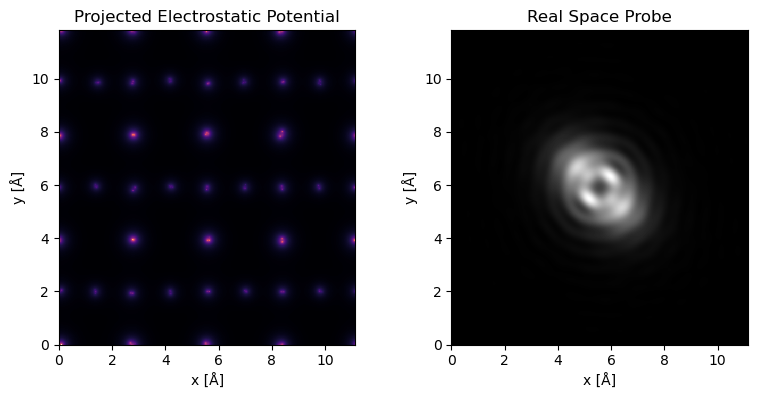

In [6]:
from abtem import FrozenPhonons, Potential
from abtem import CTF, Probe

frozen_phonons          = FrozenPhonons(STO_atoms, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
electrostatic_potential = Potential(frozen_phonons,
                                    sampling=0.02,
                                    device='gpu',
                                    projection='infinite',
                                    parametrization='kirkland').build()


ctf             = CTF(parameters={'C10': -75,'C12': 20, 'phi12': 0.785,'C30':-7e4},semiangle_cutoff=24)
probe           = Probe(semiangle_cutoff=24,
                        energy=200e3,
                        ctf=ctf,
                        device='gpu')
probe.match_grid(electrostatic_potential)


fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
electrostatic_potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential',ax=ax1)
probe.show(figsize=(4,4),title='Real Space Probe',ax=ax2)
fig.tight_layout()

We perform the 4DSTEM simulation and check how our HAADF looks like: 

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

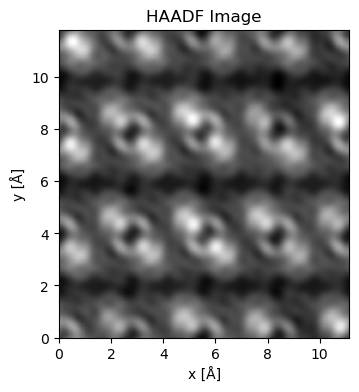

In [7]:
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan

pixelated_detector  = PixelatedDetector(max_angle=120)
gridscan            = GridScan((0,0), electrostatic_potential.extent, sampling = 0.9*probe.ctf.nyquist_sampling)
measurement         = probe.scan(gridscan, pixelated_detector, electrostatic_potential)

haadf_detector_measurement   = AnnularDetector(inner=24,outer=120).integrate(measurement)
haadf_detector_measurement   = haadf_detector_measurement.interpolate(electrostatic_potential.sampling)

haadf_detector_measurement.show(figsize=(4,4),title='HAADF Image');

We start by importing the `RegularizedPtychographicOperator` object from `abtem.reconstruct`.  
This has various options, but at the very least needs to be initialized using:  
- A `Measurement` object (or array dirrectly) representing the set of diffraction intensities  
- The `energy` the experiment was carried out and the `semiangle_cutoff` for our initial probe-guess  
  - We could also pass `defocus` and other aberrations aswell - but one of the strengths of r-PIE is reconstructing the probe aberrations, so we deliberately omit these  
  
_Note:_ The initialization further accepts a parameters dictionary, with the properties below pertaining to the simulation/experimental conditions.  
If you're passing a `Measurement` object, most of these will be automatically detected, but here we specify `object_px_padding:(0,0)` to indicate we're interested in a periodic reconstruction.

In [8]:
from abtem.reconstruct import experimental_symbols, reconstruction_symbols

experimental_symbols

('rotation_angle',
 'scan_step_sizes',
 'angular_sampling',
 'background_counts_cutoff',
 'counts_scaling_factor',
 'grid_scan_shape',
 'object_px_padding')

The object then exposes two main methods:
1. `preprocess()`, which prepares the reconstruction
2. `reconstruct()`, which performs the ptychographic reconstruction using the requested reconstruction parameters.  

_Note:_ There's a lot of hyper-parameters (such as update step sizes and regularization) one could tune here, but the default values below perform reasonably well for demonstration

In [9]:
reconstruction_symbols

{'alpha': 1.0,
 'beta': 1.0,
 'object_step_size': 1.0,
 'probe_step_size': 1.0,
 'position_step_size': 1.0,
 'step_size_damping_rate': 0.995,
 'pre_position_correction_update_steps': None,
 'pre_probe_correction_update_steps': None}

In [10]:
from abtem.reconstruct import RegularizedPtychographicOperator

electrostatic_potential_ptycho_operator = RegularizedPtychographicOperator(measurement,
                                                                           semiangle_cutoff=24,
                                                                           energy=200e3,
                                                                           device='gpu',
                                                                           parameters={'object_px_padding':(0,0)}).preprocess()

rpie_objects, rpie_probes, rpie_positions, rpie_sse = electrostatic_potential_ptycho_operator.reconstruct(max_iterations = 5,
                                                                                                          random_seed=1,
                                                                                                          verbose = True,
                                                                                                          return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 1.696e-06
----Iteration 1, SSE = 1.134e-07
----Iteration 2, SSE = 7.816e-08
----Iteration 3, SSE = 7.476e-08
----Iteration 4, SSE = 7.278e-08


_Note:_ Since we specified `verbose=True`, the reconstruction prints the steps it will take, as-well as the error of each iteration.

Let's investigate our reconstructed object and probe:

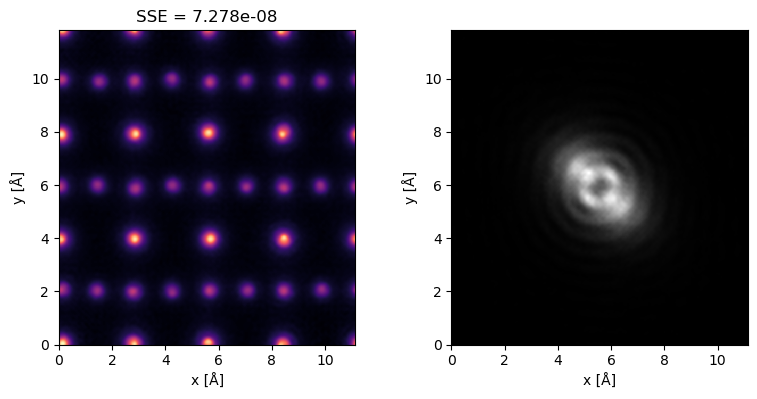

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
rpie_objects[-1].angle().interpolate(electrostatic_potential.sampling).show(ax=ax1,cmap='magma',title=f"SSE = {float(rpie_sse[-1]):.3e}")
rpie_probes[-1].intensity().interpolate(electrostatic_potential.sampling).show(ax=ax2)
fig.tight_layout()

This is quite good, the regularized-PIE algorithm is effectively converged after only a couple of iterations and has corrected all aberrations!